In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import ROOT
from ROOT import TFile, TTree, TH1F, TCanvas, TAxis, TLegend, TTreeReader, TTreeReaderValue
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

In [6]:
def make_df(outTree):
    data, columns = outTree.AsMatrix(return_labels=True)
    df_temp = pd.DataFrame(data=data, columns=columns)
    df = df_temp.iloc[:, :len(df_temp.columns)-1]
    label = df_temp.iloc[:, len(df_temp.columns)-1:len(df_temp.columns)]
    return df, label

In [7]:
def eval_regreesion(df, label, model):
    # Plot BDT output
    sig3_index_list = np.where((label.values.ravel() == 3))[0].tolist()
    sig2_index_list = np.where((label.values.ravel() == 2))[0].tolist()
    bkg1_index_list = np.where((label.values.ravel() == 1))[0].tolist()
    bkg0_index_list = np.where((label.values.ravel() == 0))[0].tolist()
    print("Number of signals 3 for testing: ", len(sig3_index_list))
    print("Number of signals 2 for testing: ", len(sig2_index_list))
    print("Number of backgrounds 1 for testing: ", len(bkg1_index_list))
    print("Number of backgrounds 0 for testing: ", len(bkg0_index_list))
    result_sig_3 = clf.predict(df.iloc[sig3_index_list])
    result_sig_2 = clf.predict(df.iloc[sig2_index_list])
    result_bkg_1 = clf.predict(df.iloc[bkg1_index_list])
    result_bkg_0 = clf.predict(df.iloc[bkg0_index_list])
    max_sig_response = max([result_sig_3.tolist(), result_sig_2.tolist()])
    max_bkg_response = max([result_bkg_1.tolist(), result_bkg_0.tolist()])
    max_response = max(max([max_sig_response, max_bkg_response]))
    
    fig = plt.figure()   
    ax0 = fig.add_subplot(3,1,1)
    plt.hist(result_sig_3,50, color='r', alpha=0.5, label="match-3")
    plt.hist(result_sig_2,50, color='orangered', alpha=0.5, label="match-2")
    plt.hist(result_bkg_1,50, color='b', alpha=0.5, label="unmatch-1")
    plt.hist(result_bkg_0,50, color='dodgerblue', alpha=0.5, label="unmatch-0")
    ax0.set_ylabel("Events")
    ax0.set_xlabel("BDT response")
    ax0.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles, labels)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    
    # Manually calculate classificiation efficiency
    sig_eff_list = []
    bkg_rej_list = []
    sig_purity_list = []
    sensitivity_list = []
    cut_list = []
    cut_90eff = -1
    for cut in np.linspace(0,3,301):
        N_sig = len(sig3_index_list+sig2_index_list)
        N_bkg = len(bkg1_index_list+bkg0_index_list)
        N_sig_pass = len([x for x in result_sig_3 if x > cut]+[y for y in result_sig_2 if y > cut])
        N_bkg_pass = len([x for x in result_bkg_1 if x > cut]+[y for y in result_bkg_0 if y > cut])
        if(N_bkg_pass == 0 or (N_sig_pass + N_bkg_pass) == 0):
            print("Dividing zero, end loop")
            break
        cut_list.append(cut)
        sig_eff_list.append(N_sig_pass / N_sig)
        if abs((N_sig_pass / N_sig) - 0.9) < 0.02:
            print(N_sig_pass / N_sig, cut_90eff)
            cut_90eff = cut
        bkg_rej_list.append(1 - N_bkg_pass / N_bkg)
        sig_purity_list.append(N_sig_pass / (N_sig_pass + N_bkg_pass))
        sensitivity_list.append(N_sig_pass / math.sqrt(N_bkg_pass))
    
    ax1 = fig.add_subplot(3,1,2)
    ax1.plot(cut_list, sig_eff_list, label="Signal efficiency", color="red")
    ax1.plot(cut_list, bkg_rej_list, label="Background rejection", color="blue")
    ax1.plot(cut_list, sig_purity_list, label="Signal purity", color="green") 
    ax1.set_ylabel("")
    ax1.set_xlabel("Cut on BDT")
    ax1.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)
    ax1.grid(True)
    ax2 = fig.add_subplot(3,1,3)
    ax2.plot(cut_list, sensitivity_list, label=r"$S/\sqrt{B}$", color="black")
    ax2.set_ylabel("")
    ax2.set_xlabel("Cut on BDT")
    ax2.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels)
    ax2.grid(True)
    fig.set_figheight(20)
    fig.set_figwidth(12)
    print("90% signal efficiency cut: ", cut_90eff)
    print("Optimal cut on BDT: ", cut_list[sensitivity_list.index(max(sensitivity_list))])
    fig.show()

In [12]:
sample = "M1-3000_R-0p7"
tempFile = TFile(f"{sample}_training.root","RECREATE")
outTree = TTree()
inFile = TFile(f"/home/xyan13/Trijet/TrijetAna/TrijetAna/outputs_3_jets/Res1ToRes2GluTo3Glu_{sample}_ML_study.root")
inTree = inFile.Get("Events")
dijet_eta = np.empty((1), dtype="float32")
dijet_phi = np.empty((1), dtype="float32")
dR_jj = np.empty((1), dtype="float32")
dEta_jj = np.empty((1), dtype="float32")
dPhi_jj = np.empty((1), dtype="float32")
dR_j0j2 = np.empty((1), dtype="float32")
dEta_j0j2 = np.empty((1), dtype="float32")
dPhi_j0j2 = np.empty((1), dtype="float32")
dR_j1j2 = np.empty((1), dtype="float32")
dEta_j1j2 = np.empty((1), dtype="float32")
dPhi_j1j2 = np.empty((1), dtype="float32")
jet_eta_0 = np.empty((1), dtype="float32")
jet_phi_0 = np.empty((1), dtype="float32")
jet_ptoverm_0 = np.empty((1), dtype="float32")
jet_eta_1 = np.empty((1), dtype="float32")
jet_phi_1 = np.empty((1), dtype="float32")
jet_ptoverm_1 = np.empty((1), dtype="float32")
jet_eta_2 = np.empty((1), dtype="float32")
jet_phi_2 = np.empty((1), dtype="float32")
jet_ptoverm_2 = np.empty((1), dtype="float32")
dR_jj_j = np.empty((1), dtype="float32")
dEta_jj_j = np.empty((1), dtype="float32")
dPhi_jj_j = np.empty((1), dtype="float32")
jet_ptoverM_0 = np.empty((1), dtype="float32")
jet_ptoverM_1 = np.empty((1), dtype="float32")
jet_ptoverM_2 = np.empty((1), dtype="float32")
dijet_ptoverM = np.empty((1), dtype="float32")
gen_dijet_matched = np.empty((1), dtype="int32")

outTree.Branch("dijet_eta", dijet_eta, "dijet_eta/F")
outTree.Branch("dijet_phi", dijet_phi, "dijet_phi/F")
outTree.Branch("dR_jj", dR_jj, "dR_jj/F")
outTree.Branch("dEta_jj", dEta_jj, "dEta_jj/F")
outTree.Branch("dPhi_jj", dPhi_jj, "dPhi_jj/F")
outTree.Branch("dR_j0j2", dR_jj, "dR_j0j2/F")
outTree.Branch("dEta_j0j2", dEta_jj, "dEta_j0j2/F")
outTree.Branch("dPhi_j0j2", dPhi_jj, "dPhi_j0j2/F")
outTree.Branch("dR_j1j2", dR_jj, "dR_j1j2/F")
outTree.Branch("dEta_j1j2", dEta_jj, "dEta_j1j2/F")
outTree.Branch("dPhi_j1j2", dPhi_jj, "dPhi_j1j2/F")
outTree.Branch("jet_eta_0", jet_eta_0, "jet_eta_0/F")
outTree.Branch("jet_phi_0", jet_phi_0, "jet_phi_0/F")
outTree.Branch("jet_ptoverm_0", jet_ptoverm_0, "jet_ptoverm_0/F")
outTree.Branch("jet_eta_1", jet_eta_1, "jet_eta_1/F")
outTree.Branch("jet_phi_1", jet_phi_1, "jet_phi_1/F")
outTree.Branch("jet_ptoverm_1", jet_ptoverm_1, "jet_ptoverm_1/F")
outTree.Branch("jet_eta_2", jet_eta_2, "jet_eta_2/F")
outTree.Branch("jet_phi_2", jet_phi_2, "jet_phi_2/F")
outTree.Branch("jet_ptoverm_2", jet_ptoverm_2, "jet_ptoverm_2/F")
outTree.Branch("dR_jj_j", dR_jj_j, "dR_jj_j/F")
outTree.Branch("dEta_jj_j", dEta_jj_j, "dEta_jj_j/F")
outTree.Branch("dPhi_jj_j", dPhi_jj_j, "dPhi_jj_j/F")
outTree.Branch("jet_ptoverM_0", jet_ptoverM_0, "jet_ptoverM_0/F")
outTree.Branch("jet_ptoverM_1", jet_ptoverM_1, "jet_ptoverM_1/F")
outTree.Branch("jet_ptoverM_2", jet_ptoverM_2, "jet_ptoverM_2/F")
outTree.Branch("dijet_ptoverM", dijet_ptoverM, "dijet_ptoverM/F")
outTree.Branch("gen_dijet_matched", gen_dijet_matched, "gen_dijet_matched/I")

n_all = inTree.GetEntries()
array_ismatch = inTree.AsMatrix(columns=["gen_dijet_matched"])
array_matched_3 = np.where((array_ismatch.ravel() == 3))[0]
array_matched_2 = np.where((array_ismatch.ravel() == 2))[0]
array_matched_1 = np.where((array_ismatch.ravel() == 1))[0]
array_matched_0 = np.where((array_ismatch.ravel() == 0))[0]
n_matched_3 = np.shape(array_matched_3)[0]
n_matched_2 = np.shape(array_matched_2)[0]
n_matched_1 = np.shape(array_matched_1)[0]
n_matched_0 = np.shape(array_matched_0)[0]
print(n_matched_3, n_matched_2, n_matched_1, n_matched_0)
scale_3 = (n_matched_3+n_matched_2+n_matched_1+n_matched_0) / n_matched_3
scale_2 = (n_matched_3+n_matched_2+n_matched_1+n_matched_0) / n_matched_2
scale_1 = (n_matched_3+n_matched_2+n_matched_1+n_matched_0) / n_matched_1
scale_0 = (n_matched_3+n_matched_2+n_matched_1+n_matched_0) / n_matched_0
ratio_3 = scale_3 / (scale_3+scale_2+scale_1+scale_0)
ratio_2 = scale_2 / (scale_3+scale_2+scale_1+scale_0)
ratio_1 = scale_1 / (scale_3+scale_2+scale_1+scale_0)
ratio_0 = scale_0 / (scale_3+scale_2+scale_1+scale_0)

from ROOT import TRandom3
rand_gen = TRandom3()
count3 = 0
count2 = 0
count1 = 0
count0 = 0
for i, event in enumerate(inTree):
    if i%10000 == 0:
        print("Processing: ",i)
    isFill = False
    random = rand_gen.Uniform(0,1)
    if(event.gen_dijet_matched == 3):
        if random < ratio_3: 
            gen_dijet_matched[0] = 3
            isFill = True
            count3 += 1
    elif(event.gen_dijet_matched == 2):
        if random < ratio_2: 
            gen_dijet_matched[0] = 2
            isFill = True
            count2 += 1
    elif(event.gen_dijet_matched == 1):
        if random < ratio_1: 
            gen_dijet_matched[0] = 1
            isFill = True
            count1 += 1
    elif(event.gen_dijet_matched == 0):
        if random < ratio_0: 
            gen_dijet_matched[0] = 0
            isFill = True
            count0 += 1
    if not isFill:
        continue
    dijet_eta[0] = event.dijet_eta
    dijet_phi[0] = event.dijet_phi
    dR_jj[0] = event.dR_jj
    dEta_jj[0] = event.dEta_jj
    dPhi_jj[0] = event.dPhi_jj
    dR_j0j2[0] = event.dR_j0j2
    dEta_j0j2[0] = event.dEta_j0j2
    dPhi_j0j2[0] = event.dPhi_j0j2
    dR_j1j2[0] = event.dR_j1j2
    dEta_j1j2[0] = event.dEta_j1j2
    dPhi_j1j2[0] = event.dPhi_j1j2
    jet_eta_0[0] = event.jet_eta_0
    jet_phi_0[0] = event.jet_phi_0
    jet_ptoverm_0[0] = event.jet_ptoverm_0
    jet_eta_1[0] = event.jet_eta_1
    jet_phi_1[0] = event.jet_phi_1
    jet_ptoverm_1[0] = event.jet_ptoverm_1
    jet_eta_2[0] = event.jet_eta_2
    jet_phi_2[0] = event.jet_phi_2
    jet_ptoverm_2[0] = event.jet_ptoverm_2
    dR_jj_j[0] = event.dR_jj_j
    dEta_jj_j[0] = event.dEta_jj_j
    dPhi_jj_j[0] = event.dPhi_jj_j
    jet_ptoverM_0[0] = event.jet_ptoverM_0
    jet_ptoverM_1[0] = event.jet_ptoverM_1
    jet_ptoverM_2[0] = event.jet_ptoverM_2
    dijet_ptoverM[0] = event.dijet_ptoverM
    outTree.Fill()
df_1 = pd.DataFrame()
label_1 = pd.DataFrame()
df_1, label_1 = make_df(outTree)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1, label_1, test_size=0.33, random_state=1, stratify=label_1)
print(count3, count2, count1, count0)

26047 15858 81092 21195
Processing:  0
Processing:  10000
Processing:  20000
Processing:  30000
Processing:  40000
Processing:  50000
Processing:  60000
Processing:  70000
Processing:  80000
Processing:  90000
Processing:  100000
Processing:  110000
Processing:  120000
Processing:  130000
Processing:  140000
6291 6232 6196 6183


In [13]:
# This cell is intended for the single traning
df_train = X_train_1
label_train = y_train_1
df_test = X_test_1
label_test = y_test_1
display(df_train.head())
display(label_train.head())
label_arr = np.array(label_train.iloc[1:,:]).ravel()
all_N = np.shape(label_arr)
sig_N = np.shape(np.where(label_arr == 1))
print(all_N, sig_N)

,dijet_eta,dijet_phi,dR_jj,dEta_jj,dPhi_jj,dR_j0j2,dEta_j0j2,dPhi_j0j2,dR_j1j2,dEta_j1j2,...,jet_eta_2,jet_phi_2,jet_ptoverm_2,dR_jj_j,dEta_jj_j,dPhi_jj_j,jet_ptoverM_0,jet_ptoverM_1,jet_ptoverM_2,dijet_ptoverM
11292,1.703848,0.632052,2.925543,0.388306,2.899658,2.925543,0.388306,2.899658,2.925543,0.388306,...,1.546631,-2.593750,0.400690,3.061423,0.157217,3.057383,0.427245,0.236950,0.259176,0.205204
24706,-1.337440,2.475800,3.340356,2.288940,2.432843,3.340356,2.288940,2.432843,3.340356,2.288940,...,-0.220642,-2.352539,0.201355,1.834071,1.116798,1.454847,0.295847,0.207581,0.169554,0.193313
5189,0.792278,1.970798,2.325253,0.426697,2.285767,2.325253,0.426697,2.285767,2.325253,0.426697,...,1.125000,-1.397949,0.415869,2.933369,0.332722,2.914438,0.365029,0.301655,0.259405,0.282601
9132,-0.004534,2.768947,1.849057,0.847229,1.643537,1.849057,0.847229,1.643537,1.849057,0.847229,...,-0.409485,-0.453003,0.714295,3.087903,0.404951,3.061235,0.358642,0.222798,0.346735,0.408226
18728,0.190894,-0.491381,2.829003,1.288940,2.518311,2.829003,1.288940,2.518311,2.829003,1.288940,...,0.986206,2.566895,0.309148,3.159996,0.795312,3.058276,0.293342,0.292135,0.213120,0.179523


,gen_dijet_matched
11292,3.0
24706,1.0
5189,2.0
9132,1.0
18728,3.0


(16683,) (1, 4151)


In [ ]:
# This cell is intended for mix traning using two samples
N2train = min(X_train_1.shape[0], X_train_2.shape[0])
print(N2train)
df_train = pd.concat([X_train_1.iloc[:N2train, :], X_train_2.iloc[:N2train, :]])
label_train = pd.concat([y_train_1.iloc[:N2train, :], y_train_2.iloc[:N2train, :]])
print(df_train.shape[0])
N2test = min(X_test_1.shape[0], X_test_2.shape[0])
print(N2test)
df_test = pd.concat([X_test_1.iloc[:N2test, :], X_test_2.iloc[:N2test, :]])
label_test = pd.concat([y_test_1.iloc[:N2test, :], y_test_2.iloc[:N2test, :]])
print(df_test.shape[0])

['dijet_eta', 'dijet_phi', 'dR_jj', 'dEta_jj', 'dPhi_jj', 'dR_j0j2', 'dEta_j0j2', 'dPhi_j0j2', 'dR_j1j2', 'dEta_j1j2', 'dPhi_j1j2', 'jet_eta_0', 'jet_phi_0', 'jet_ptoverm_0', 'jet_eta_1', 'jet_phi_1', 'jet_ptoverm_1', 'jet_eta_2', 'jet_phi_2', 'jet_ptoverm_2', 'dR_jj_j', 'dEta_jj_j', 'dPhi_jj_j', 'jet_ptoverM_0', 'jet_ptoverM_1', 'jet_ptoverM_2', 'dijet_ptoverM']


,PC1,PC2,gen_dijet_matched
0,-0.897631,0.475155,3.0
1,-0.961123,-0.150083,3.0
2,3.797401,-0.452220,1.0
3,-2.331935,-0.395023,2.0
4,1.022363,-0.994292,2.0


dR_j1j2    0.327174
dR_j0j2    0.327174
dR_jj      0.327174
dtype: float64

dEta_jj      0.44579
dEta_j0j2    0.44579
dEta_j1j2    0.44579
dtype: float64

dR_jj_j      0.570934
dEta_jj_j    0.530218
dijet_eta    0.300462
dtype: float64

dijet_eta    0.535632
jet_eta_0    0.435641
jet_eta_1    0.338131
dtype: float64

jet_phi_0    0.510132
dijet_phi    0.499331
jet_phi_2    0.431427
dtype: float64

dPhi_jj_j        0.652322
jet_ptoverM_0    0.386928
jet_ptoverM_1    0.347509
dtype: float64

jet_phi_1    0.890128
jet_phi_2    0.351143
dijet_phi    0.165077
dtype: float64

jet_eta_2    0.653159
jet_eta_1    0.635767
jet_eta_0    0.350569
dtype: float64

jet_eta_2    0.687615
jet_eta_0    0.489528
jet_eta_1    0.452124
dtype: float64

jet_ptoverM_1    0.493292
jet_ptoverm_0    0.414597
dPhi_jj_j        0.405592
dtype: float64

jet_ptoverM_2    0.548901
jet_ptoverM_0    0.429317
dijet_ptoverM    0.377266
dtype: float64

jet_phi_2    0.778766
dijet_phi    0.426271
jet_phi_0    0.347254
dtype: float64

jet_ptoverm_1    0.523112
jet_ptoverm_0    0.407062
jet_ptoverM_2    0.329602
dtype: float64

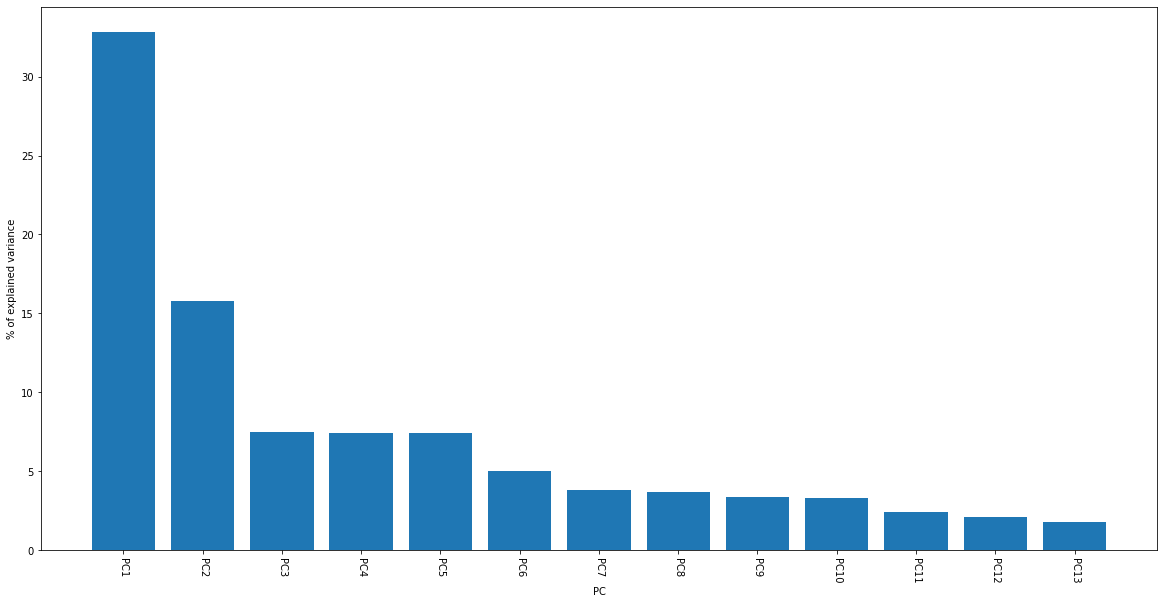

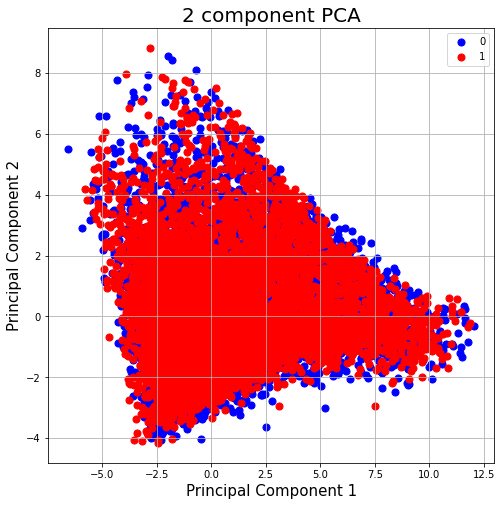

In [16]:
# This cell is intended for PCA analysis, can be run seperately from ML traning
variables = [var for var in df_1.columns[:len(df_1.columns)]]
print(variables)
scaled_df = preprocessing.scale(df_1)
pca = PCA(0.95)
pca.fit(scaled_df)
PCA_df = pca.transform(scaled_df)
PCA_df = pd.DataFrame(data = PCA_df[:,:2],columns = ["PC1","PC2"])
PCA_df_final = pd.concat([PCA_df,label_1] ,axis = 1)
display(PCA_df_final.head())
# Calculate percentage variation
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
# Calculate loading scores, determine best variables of each PCs
for i in range(0, len(per_var)):
    loading_scores = pd.Series(pca.components_[i], index=variables)
    loading_scores = loading_scores.abs().sort_values(ascending=False)
    display(loading_scores[:3])
labels = ["PC" + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(20,10))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel("% of explained variance")
plt.xlabel("PC")
plt.xticks(rotation=270)
plt.show()
# display(pca.components_)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ["b","r"]
for target, color in zip(targets,colors):
    indicesToKeep = PCA_df_final["gen_dijet_matched"] == target
    ax.scatter(PCA_df_final.loc[indicesToKeep, "PC1"],
               PCA_df_final.loc[indicesToKeep, "PC2"],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

In [14]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# clf = MLPClassifier(solver='adam',hidden_layer_sizes=(20,20),random_state=1)
clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=200, random_state=1)
clf.fit(df_train, label_train.values.ravel())
# Score the fit using the pure QCD or Signal data
# X_test = scaler.transform(X_test)
# print(clf.score(X_test,y_test.values.ravel()))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=200, random_state=1)

Number of signals 3 for testing:  2076
Number of signals 2 for testing:  2057
Number of backgrounds 1 for testing:  2045
Number of backgrounds 0 for testing:  2040
0.9172513912412291 -1
0.913622066295669 1.0
0.913622066295669 1.01
0.913622066295669 1.02
0.9126542463101863 1.03
0.9080571013791435 1.04
0.9080571013791435 1.05
0.9070892813936607 1.06
0.8812000967819985 1.07
Dividing zero, end loop
90% signal efficiency cut:  1.08
Optimal cut on BDT:  1.31
Number of signals 3 for testing:  4215
Number of signals 2 for testing:  4175
Number of backgrounds 1 for testing:  4151
Number of backgrounds 0 for testing:  4143
0.9189511323003575 -1
0.9189511323003575 1.01
0.9189511323003575 1.02
0.9177592371871275 1.03
0.9154946364719905 1.04
0.9154946364719905 1.05
0.9138259833134684 1.06
0.8910607866507747 1.07
0.8858164481525626 1.08
0.8833134684147795 1.09
Dividing zero, end loop
90% signal efficiency cut:  1.1
Optimal cut on BDT:  1.36


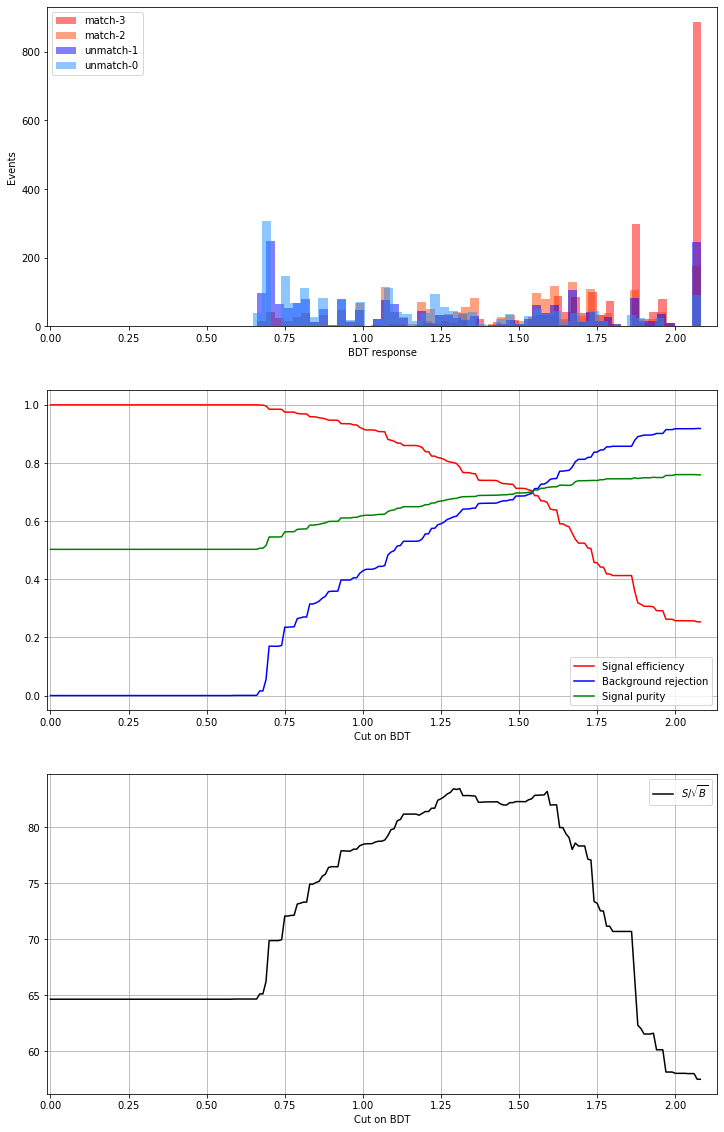

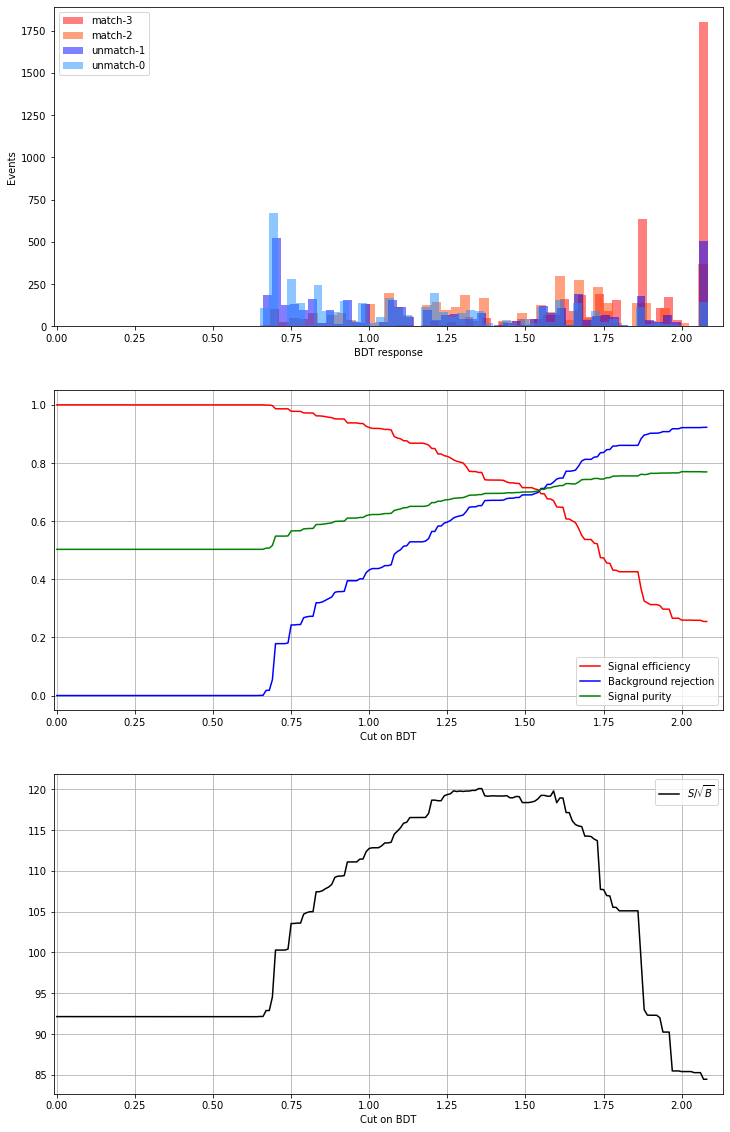

In [15]:
eval_regreesion(df_test, label_test, clf)
eval_regreesion(df_train, label_train, clf)

In [45]:
from joblib import dump, load
dump(clf, 'BDT_model_matching_0_1_2_3.joblib') 

['BDT_model_matching_0_1_2_3.joblib']

22946 18461 81129 25979
Processing:  0
Processing:  10000
Processing:  20000
Processing:  30000
Processing:  40000
Processing:  50000
Processing:  60000
Processing:  70000
Processing:  80000
Processing:  90000
Processing:  100000
Processing:  110000
Processing:  120000
Processing:  130000
Processing:  140000
Number of signals 3 for testing:  6663
Number of signals 2 for testing:  6727
Number of backgrounds 1 for testing:  6689
Number of backgrounds 0 for testing:  6736


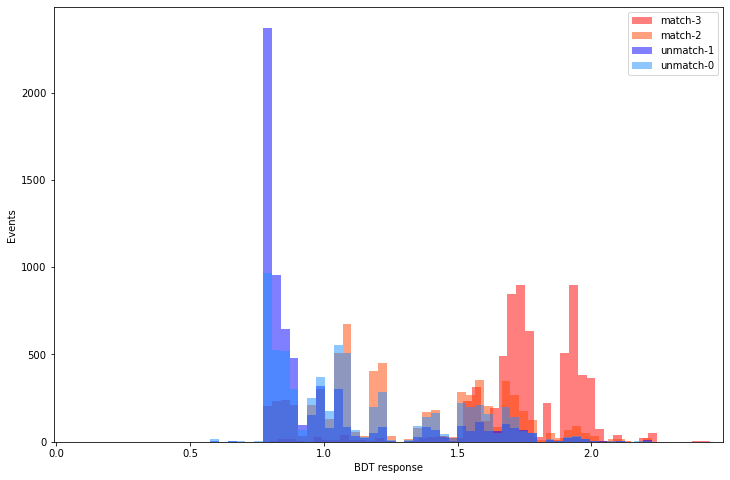

In [40]:
# Evaluation using another signal sample
sample = "M1-7000_R-0p3"
tempFile = TFile(f"{sample}_training.root","RECREATE")
outTree = TTree()
inFile = TFile(f"/home/xyan13/Trijet/TrijetAna/TrijetAna/outputs_3_jets/Res1ToRes2GluTo3Glu_{sample}_ML_study.root")
inTree = inFile.Get("Events")
dijet_eta = np.empty((1), dtype="float32")
dijet_phi = np.empty((1), dtype="float32")
dR_jj = np.empty((1), dtype="float32")
dEta_jj = np.empty((1), dtype="float32")
dPhi_jj = np.empty((1), dtype="float32")
dR_j0j2 = np.empty((1), dtype="float32")
dEta_j0j2 = np.empty((1), dtype="float32")
dPhi_j0j2 = np.empty((1), dtype="float32")
dR_j1j2 = np.empty((1), dtype="float32")
dEta_j1j2 = np.empty((1), dtype="float32")
dPhi_j1j2 = np.empty((1), dtype="float32")
jet_eta_0 = np.empty((1), dtype="float32")
jet_phi_0 = np.empty((1), dtype="float32")
jet_ptoverm_0 = np.empty((1), dtype="float32")
jet_eta_1 = np.empty((1), dtype="float32")
jet_phi_1 = np.empty((1), dtype="float32")
jet_ptoverm_1 = np.empty((1), dtype="float32")
jet_eta_2 = np.empty((1), dtype="float32")
jet_phi_2 = np.empty((1), dtype="float32")
jet_ptoverm_2 = np.empty((1), dtype="float32")
dR_jj_j = np.empty((1), dtype="float32")
dEta_jj_j = np.empty((1), dtype="float32")
dPhi_jj_j = np.empty((1), dtype="float32")
jet_ptoverM_0 = np.empty((1), dtype="float32")
jet_ptoverM_1 = np.empty((1), dtype="float32")
jet_ptoverM_2 = np.empty((1), dtype="float32")
dijet_ptoverM = np.empty((1), dtype="float32")
gen_dijet_matched = np.empty((1), dtype="int32")

outTree.Branch("dijet_eta", dijet_eta, "dijet_eta/F")
outTree.Branch("dijet_phi", dijet_phi, "dijet_phi/F")
outTree.Branch("dR_jj", dR_jj, "dR_jj/F")
outTree.Branch("dEta_jj", dEta_jj, "dEta_jj/F")
outTree.Branch("dPhi_jj", dPhi_jj, "dPhi_jj/F")
outTree.Branch("dR_j0j2", dR_jj, "dR_j0j2/F")
outTree.Branch("dEta_j0j2", dEta_jj, "dEta_j0j2/F")
outTree.Branch("dPhi_j0j2", dPhi_jj, "dPhi_j0j2/F")
outTree.Branch("dR_j1j2", dR_jj, "dR_j1j2/F")
outTree.Branch("dEta_j1j2", dEta_jj, "dEta_j1j2/F")
outTree.Branch("dPhi_j1j2", dPhi_jj, "dPhi_j1j2/F")
outTree.Branch("jet_eta_0", jet_eta_0, "jet_eta_0/F")
outTree.Branch("jet_phi_0", jet_phi_0, "jet_phi_0/F")
outTree.Branch("jet_ptoverm_0", jet_ptoverm_0, "jet_ptoverm_0/F")
outTree.Branch("jet_eta_1", jet_eta_1, "jet_eta_1/F")
outTree.Branch("jet_phi_1", jet_phi_1, "jet_phi_1/F")
outTree.Branch("jet_ptoverm_1", jet_ptoverm_1, "jet_ptoverm_1/F")
outTree.Branch("jet_eta_2", jet_eta_2, "jet_eta_2/F")
outTree.Branch("jet_phi_2", jet_phi_2, "jet_phi_2/F")
outTree.Branch("jet_ptoverm_2", jet_ptoverm_2, "jet_ptoverm_2/F")
outTree.Branch("dR_jj_j", dR_jj_j, "dR_jj_j/F")
outTree.Branch("dEta_jj_j", dEta_jj_j, "dEta_jj_j/F")
outTree.Branch("dPhi_jj_j", dPhi_jj_j, "dPhi_jj_j/F")
outTree.Branch("jet_ptoverM_0", jet_ptoverM_0, "jet_ptoverM_0/F")
outTree.Branch("jet_ptoverM_1", jet_ptoverM_1, "jet_ptoverM_1/F")
outTree.Branch("jet_ptoverM_2", jet_ptoverM_2, "jet_ptoverM_2/F")
outTree.Branch("dijet_ptoverM", dijet_ptoverM, "dijet_ptoverM/F")
outTree.Branch("gen_dijet_matched", gen_dijet_matched, "gen_dijet_matched/I")

n_all = inTree.GetEntries()
array_ismatch = inTree.AsMatrix(columns=["gen_dijet_matched"])
array_matched_3 = np.where((array_ismatch.ravel() == 3))[0]
array_matched_2 = np.where((array_ismatch.ravel() == 2))[0]
array_matched_1 = np.where((array_ismatch.ravel() == 1))[0]
array_matched_0 = np.where((array_ismatch.ravel() == 0))[0]
n_matched_3 = np.shape(array_matched_3)[0]
n_matched_2 = np.shape(array_matched_2)[0]
n_matched_1 = np.shape(array_matched_1)[0]
n_matched_0 = np.shape(array_matched_0)[0]
print(n_matched_3, n_matched_2, n_matched_1, n_matched_0)
scale_3 = (n_matched_3+n_matched_2+n_matched_1+n_matched_0) / n_matched_3
scale_2 = (n_matched_3+n_matched_2+n_matched_1+n_matched_0) / n_matched_2
scale_1 = (n_matched_3+n_matched_2+n_matched_1+n_matched_0) / n_matched_1
scale_0 = (n_matched_3+n_matched_2+n_matched_1+n_matched_0) / n_matched_0
ratio_3 = scale_3 / (scale_3+scale_2+scale_1+scale_0)
ratio_2 = scale_2 / (scale_3+scale_2+scale_1+scale_0)
ratio_1 = scale_1 / (scale_3+scale_2+scale_1+scale_0)
ratio_0 = scale_0 / (scale_3+scale_2+scale_1+scale_0)

from ROOT import TRandom3
rand_gen = TRandom3()
count3 = 0
count2 = 0
count1 = 0
count0 = 0
for i, event in enumerate(inTree):
    if i%10000 == 0:
        print("Processing: ",i)
    isFill = False
    random = rand_gen.Uniform(0,1)
    if(event.gen_dijet_matched == 3):
        if random < ratio_3: 
            gen_dijet_matched[0] = 3
            isFill = True
            count3 += 1
    elif(event.gen_dijet_matched == 2):
        if random < ratio_2: 
            gen_dijet_matched[0] = 2
            isFill = True
            count2 += 1
    elif(event.gen_dijet_matched == 1):
        if random < ratio_1: 
            gen_dijet_matched[0] = 1
            isFill = True
            count1 += 1
    elif(event.gen_dijet_matched == 0):
        if random < ratio_0: 
            gen_dijet_matched[0] = 0
            isFill = True
            count0 += 1
    if not isFill:
        continue
    dijet_eta[0] = event.dijet_eta
    dijet_phi[0] = event.dijet_phi
    dR_jj[0] = event.dR_jj
    dEta_jj[0] = event.dEta_jj
    dPhi_jj[0] = event.dPhi_jj
    dR_j0j2[0] = event.dR_j0j2
    dEta_j0j2[0] = event.dEta_j0j2
    dPhi_j0j2[0] = event.dPhi_j0j2
    dR_j1j2[0] = event.dR_j1j2
    dEta_j1j2[0] = event.dEta_j1j2
    dPhi_j1j2[0] = event.dPhi_j1j2
    jet_eta_0[0] = event.jet_eta_0
    jet_phi_0[0] = event.jet_phi_0
    jet_ptoverm_0[0] = event.jet_ptoverm_0
    jet_eta_1[0] = event.jet_eta_1
    jet_phi_1[0] = event.jet_phi_1
    jet_ptoverm_1[0] = event.jet_ptoverm_1
    jet_eta_2[0] = event.jet_eta_2
    jet_phi_2[0] = event.jet_phi_2
    jet_ptoverm_2[0] = event.jet_ptoverm_2
    dR_jj_j[0] = event.dR_jj_j
    dEta_jj_j[0] = event.dEta_jj_j
    dPhi_jj_j[0] = event.dPhi_jj_j
    jet_ptoverM_0[0] = event.jet_ptoverM_0
    jet_ptoverM_1[0] = event.jet_ptoverM_1
    jet_ptoverM_2[0] = event.jet_ptoverM_2
    dijet_ptoverM[0] = event.dijet_ptoverM
    outTree.Fill()
df_1 = pd.DataFrame()
label_1 = pd.DataFrame()
df_1, label_1 = make_df(outTree)
eval_regreesion(df_1, label_1, clf)